# Simplified Welfare Benefit Domain Experiment

In [1]:
from simplified_dataset import *
from wb_dataset_helpers import *
from neural_networks import *

from tqdm import tqdm
from joblib import Parallel, delayed

%load_ext autoreload
%autoreload 2

# Increase resolution of plots
plt.rcParams['figure.dpi'] = 150

# Show more columns
pd.set_option('display.max_column',None)

### Initialize global parameters

In [2]:
# dataset parameters
db_size = 50000

# Network parameters
hidden_layers = [(12), (24, 6), (24,10,3)]
activation = 'logistic'
max_iter = 50000
learning_rate_init = 0.001
solver = 'adam'
batch_size = 50

### Initialize Regular Datasets

In [3]:
train_df = create_training_data(db_size=db_size)
test_df = create_training_data(db_size=db_size)

### Initialize Rationale Evaluation Datasets

In [4]:
ag_df = create_age_gender_dataset()
pd_df = create_patient_distance_dataset()

### Initialize Tailored Dataset

In [5]:
tailored_df = create_training_data_tailored(db_size=db_size)

### Preprocess

In [6]:
# Create a scaler to normalize the data
scaler = create_scaler(create_unique_dataset())

# Apply preprocessing to all datasets
train_X, train_y = preprocess(train_df, scaler)
test_X, test_y = preprocess(test_df, scaler)
tailored_X, tailored_y = preprocess(tailored_df, scaler)
ag_X, ag_y = preprocess(ag_df, scaler)
pd_X, pd_y = preprocess(pd_df, scaler)

### Train Networks on both regular and tailored training data

In [7]:
def create_network(layers):
    return MLPClassifier(activation=activation, hidden_layer_sizes=layers, 
                         max_iter=max_iter, learning_rate_init=learning_rate_init,
                         solver=solver, batch_size=batch_size)

def train_networks(nn, X, y):
    nn.fit(X, y)
    return nn

In [8]:
# Create and train the neural networks on regular training data
neural_nets = [create_network(hls) for hls in hidden_layers]   
neural_nets = Parallel(n_jobs=-1)(delayed(train_networks)(nn, train_X, train_y) 
                                 for nn in tqdm(neural_nets))

# # Create and train the neural networks on tailored training data
neural_nets_tailored = [create_network(hls) for hls in hidden_layers]
neural_nets_tailored = Parallel(n_jobs=-1)(delayed(train_networks)(nn, tailored_X, tailored_y) 
                                 for nn in tqdm(neural_nets_tailored))

100%|██████████| 3/3 [00:00<00:00, 2999.50it/s]


## Test performance of each network on the regular dataset and rationale evaluation datasets

In [9]:
# Store the predictions of the networks in their respective dataframes for later analysis
for idx, (nn, nn_tailored) in enumerate(zip(neural_nets, neural_nets_tailored)):
    test_df['prediction_'+str(idx+1)] = nn.predict_proba(test_X)[:,1]
    ag_df['prediction_'+str(idx+1)] = nn.predict_proba(ag_X)[:,1]
    pd_df['prediction_'+str(idx+1)] = nn.predict_proba(pd_X)[:,1]
    
    test_df['prediction_tailored_'+str(idx+1)] = nn_tailored.predict_proba(test_X)[:,1]
    ag_df['prediction_tailored_'+str(idx+1)] = nn_tailored.predict_proba(ag_X)[:,1]
    pd_df['prediction_tailored_'+str(idx+1)] = nn_tailored.predict_proba(pd_X)[:,1]

In [11]:
# Show accuracies of networks trained on training set A 
accs = pd.DataFrame.from_dict({'A '+str(idx+1) + ' layers': {
    'regular': round(100*accuracy_score(test_y, nn.predict(test_X)), 2),
    'ag': round(100*accuracy_score(ag_y, nn.predict(ag_X)), 2),
    'pd': round(100*accuracy_score(pd_y, nn.predict(pd_X)), 2),
} for idx, nn in enumerate(neural_nets)}, orient='index')
accs.to_csv('results/accuracies/accuracies_simplified.csv')
accs

,regular,ag,pd
A 1 layers,99.08,99.76,97.84
A 2 layers,99.71,99.43,97.93
A 3 layers,99.42,99.98,97.74


In [12]:
# Show accuracies of networks trained on training set B 
accs = pd.DataFrame.from_dict({'B '+str(idx+1) + ' layers':{
    'regular': round(100*accuracy_score(test_y, nn.predict(test_X)), 2),
    'ag': round(100*accuracy_score(ag_y, nn.predict(ag_X)), 2),
    'pd': round(100*accuracy_score(pd_y, nn.predict(pd_X)), 2),
} for idx, nn in enumerate(neural_nets_tailored)}, orient='index')
accs.to_csv('results/accuracies/accuracies_simplified_tailored.csv')
accs

,regular,ag,pd
B 1 layers,99.38,99.65,97.84
B 2 layers,99.84,99.83,99.38
B 3 layers,99.82,99.91,99.54


### Explore the Rationale visually for networks trained on regular training datasets

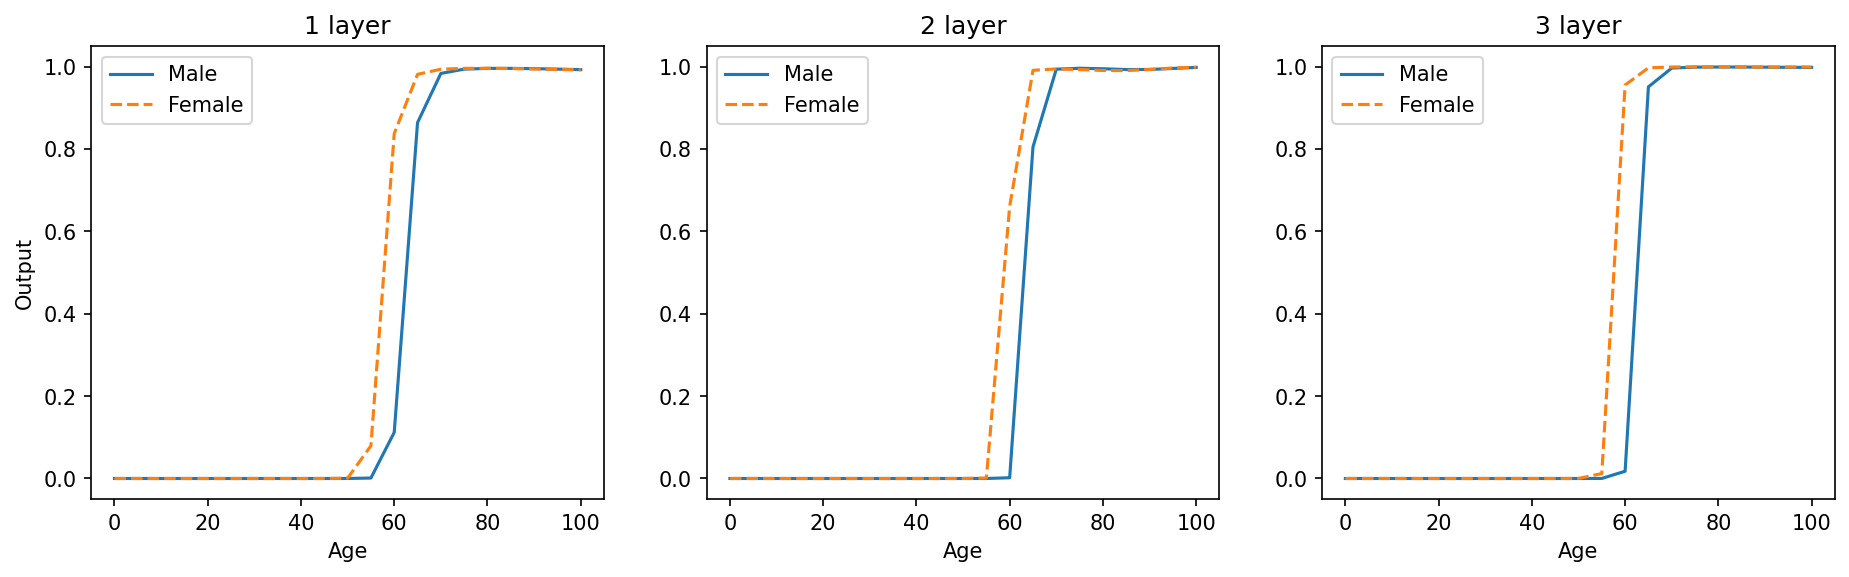

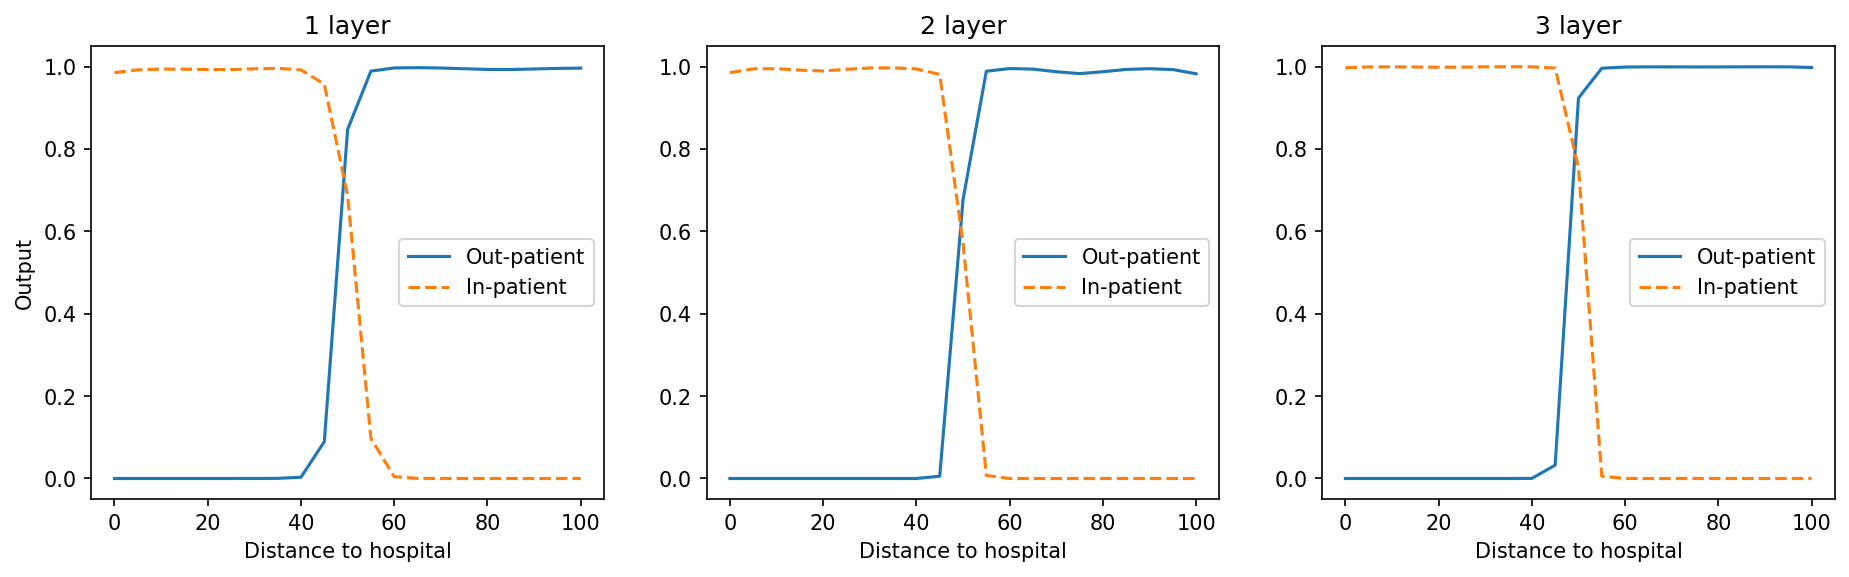

In [13]:
# Plot the age versus the output for each gender and each network
plot_output(ag_df, 'gender', 'age', ['m', 'f'], predict='prediction_',
            legend_values=['Male', 'Female'], xlabel='Age')

# Plot the distance versus the output for each patient type and each network
plot_output(pd_df, 'patient_type', 'distance_to_hospital', ['out', 'in'], predict='prediction_',
           legend_values=['Out-patient', 'In-patient'], xlabel='Distance to hospital')

### Explore the Rationale visually for networks trained on tailored training datasets

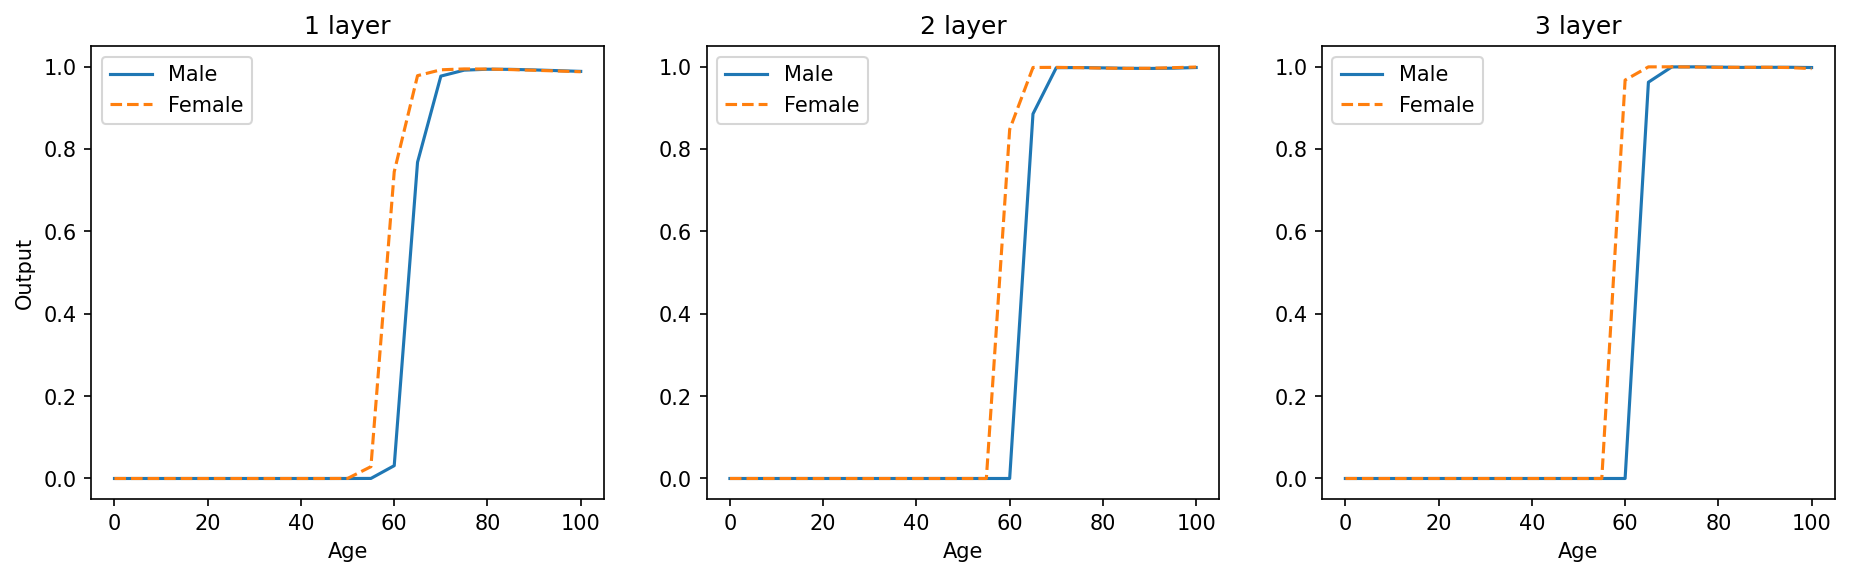

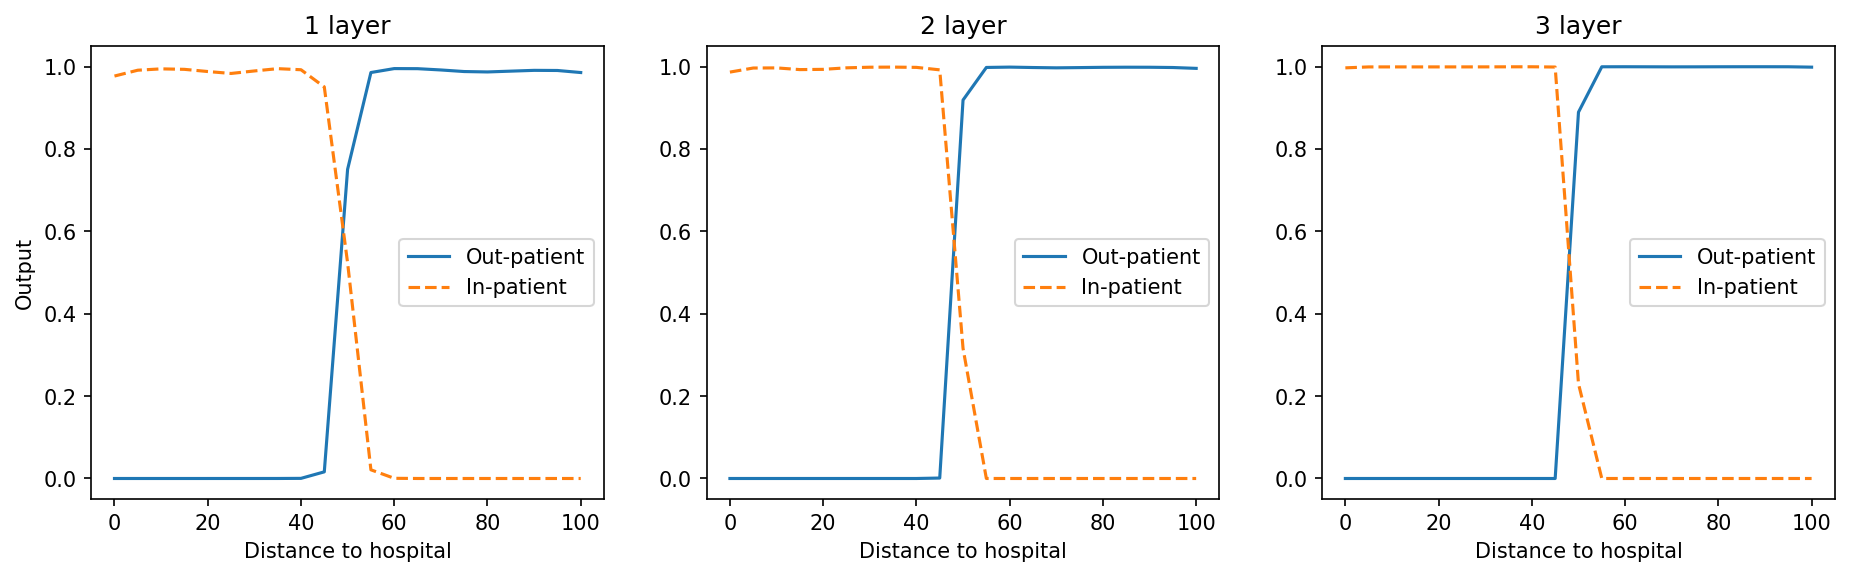

In [14]:
# Plot the age versus the output for each gender and each network
plot_output(ag_df, 'gender', 'age', ['m', 'f'], predict='prediction_tailored_',
            legend_values=['Male', 'Female'], xlabel='Age')

# Plot the distance versus the output for each patient type and each network
plot_output(pd_df, 'patient_type', 'distance_to_hospital', ['out', 'in'], predict='prediction_tailored_',
            legend_values=['Out-patient', 'In-patient'], xlabel='Distance to hospital')

### Run the experiment multiple times

In [24]:
def convert_accs(accs):
    '''
    Converts list of accuracies to mean and std
    '''
    return str(round(np.mean(accs), 2)) + ' ± ' + str(round(np.std(accs), 2))   

def merge_accuracies(accuracies):
    '''
    Merge the list of accuracies to a pandas dataframe with mean and standard deviations
    '''
    accs = copy.deepcopy(accuracies)
    results = accs[0]
    for idx, x in enumerate(accs):
        if idx == 0: continue
        for train_name, train_data in x.items():
            for test_name, test_data in train_data.items():
                results[train_name][test_name].append(test_data[0])
                if idx == len(accs)-1:
                    results[train_name][test_name] = convert_accs(results[train_name][test_name])
    return pd.DataFrame.from_dict(results).T

def run_experiment(scaler):
    '''
    Train and test neural networks
    '''

    accuracies = {}

    # Training datasets
    datasets_train = {
        'train_regular' : create_training_data(db_size=db_size),
        'train_tailored' : create_training_data_tailored(db_size=db_size),
    }
    preprocessed_train = {name: preprocess(df, scaler) for name, df in datasets_train.items()}

    # Test datasets
    datasets_test = {
        'test_A' : create_training_data(db_size=db_size),
        'ag' : create_age_gender_dataset(),
        'pd' : create_patient_distance_dataset(),   
    }
    preprocessed_test = {name: preprocess(df, scaler) for name, df in datasets_test.items()}
    
    for train_name, train_data in preprocessed_train.items():       
        # Create and train neural networks for all training datasets
        neural_nets = [create_network(hls) for hls in hidden_layers]   
        neural_nets = Parallel(n_jobs=1)(delayed(train_networks)(nn, train_data[0], train_data[1]) 
                                         for nn in neural_nets)
        
        # Initialize accuracies data
        for idx, nn in enumerate(neural_nets):
            accuracies[train_name+'_'+str(idx+1)] = {test_name: [] for test_name in preprocessed_test.keys()}

        # Add accuracies for each test dataset
        for test_name, test_data in preprocessed_test.items():
            for idx, nn in enumerate(neural_nets):
                accuracies[train_name+'_'+str(idx+1)][test_name].append(100*accuracy_score(test_data[1], nn.predict(test_data[0])))

    return accuracies

In [25]:
# Number of runs
num_runs = 50

# Create a scaler to normalize the data
scaler = create_scaler(create_training_data(db_size=db_size))   
accuracies = Parallel(n_jobs=-1)(delayed(run_experiment)(scaler) for run in tqdm(range(0, num_runs)))
results = merge_accuracies(accuracies)
results.to_csv('results/accuracies/50_runs_simplified.csv')
results